# The Stanford Sentiment Treebank 
The Stanford Sentiment Treebank consists of sentences from movie reviews and human annotations of their sentiment. The task is to predict the sentiment of a given sentence. We use the two-way (positive/negative) class split, and use only sentence-level labels.

In [ ]:
from IPython.display import display, Markdown
with open('../../doc/env_variables_setup.md', 'r') as fh:
    content = fh.read()
display(Markdown(content))

## Import Packages

In [1]:
import tensorflow as tf
import tensorflow_datasets

from tensorflow.keras.utils import to_categorical

from transformers import (
    BertConfig,
    BertTokenizer,
    XLMRobertaTokenizer,
    TFBertModel,
    TFXLMRobertaModel,
    TFBertForSequenceClassification,
    glue_convert_examples_to_features,
    glue_processors
)

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

from google.cloud import storage

import math
import numpy as np
import os
import glob
import time
from datetime import timedelta
import shutil
from datetime import datetime
import pickle
import re

## Check configuration

In [2]:
print(tf.version.GIT_VERSION, tf.version.VERSION)

v2.1.0-rc2-17-ge5bf8de410 2.1.0


In [3]:
print(tf.keras.__version__)

2.2.4-tf


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)>0:
    for gpu in gpus:
        print('Name:', gpu.name, '  Type:', gpu.device_type)
else:
    print('No GPU available !!!!')

No GPU available !!!!


## Define Paths

In [5]:
try:
    data_dir=os.environ['PATH_DATASETS']
except KeyError:
    print('missing PATH_DATASETS')
try:   
    tensorboard_dir=os.environ['PATH_TENSORBOARD']
except KeyError:
    print('missing PATH_TENSORBOARD')
try:   
    savemodel_dir=os.environ['PATH_SAVE_MODEL']
except KeyError:
    print('missing PATH_SAVE_MODEL')

## Import local packages

In [38]:
import preprocessing.preprocessing as pp
import utils.model_metrics as mm
import utils.model_utils as mu
import model.tf_custom_bert_classification.model as tf_custom_bert
import model.tf_bert_classification.model as tf_bert

In [176]:
import importlib
importlib.reload(pp);
importlib.reload(mm);
importlib.reload(mu);
importlib.reload(tf_bert);
importlib.reload(tf_custom_bert);

## Read data from TFRecord files

In [17]:
# Path of the directory with TFRecord files
tfrecord_data_dir=data_dir+'/tfrecord/sst2'

In [18]:
# TFRecords encode and store data
train_files = tf.data.TFRecordDataset(tfrecord_data_dir+'/train_dataset.tfrecord')
test_files = tf.data.TFRecordDataset(tfrecord_data_dir+'/test_dataset.tfrecord')
valid_files = tf.data.TFRecordDataset(tfrecord_data_dir+'/valid_dataset.tfrecord')

In [20]:
train_dataset = train_files.map(pp.parse_tfrecord_glue_files)
test_dataset = test_files.map(pp.parse_tfrecord_glue_files)
valid_dataset = valid_files.map(pp.parse_tfrecord_glue_files)

In [21]:
# adding the number of entries
if tf.version.VERSION[0:5]=='2.2.0':
    train_dataset=train_dataset2.apply(tf.data.experimental.assert_cardinality(train_dataset2.reduce(0, lambda x, _: x + 1).numpy()))
    test_dataset=test_dataset2.apply(tf.data.experimental.assert_cardinality(test_dataset2.reduce(0, lambda x, _: x + 1).numpy()))
    valid_dataset=valid_dataset2.apply(tf.data.experimental.assert_cardinality(valid_dataset2.reduce(0, lambda x, _: x + 1).numpy()))

## Define parameters of the model

In [22]:
# models
#MODELS = [(TFBertModel,     BertTokenizer,       'bert-base-multilingual-uncased'),
#          (OpenAIGPTModel,  OpenAIGPTTokenizer,  'openai-gpt'),
#          (GPT2Model,       GPT2Tokenizer,       'gpt2'),
#          (CTRLModel,       CTRLTokenizer,       'ctrl'),
#          (TransfoXLModel,  TransfoXLTokenizer,  'transfo-xl-wt103'),
#          (XLNetModel,      XLNetTokenizer,      'xlnet-base-cased'),
#          (XLMModel,        XLMTokenizer,        'xlm-mlm-enfr-1024'),
#          (DistilBertModel, DistilBertTokenizer, 'distilbert-base-cased'),
#          (RobertaModel,    RobertaTokenizer,    'roberta-base'),
#          (XLMRobertaModel, XLMRobertaTokenizer, 'xlm-roberta-base'),
#         ]
MODELS = [(TFBertModel,         BertTokenizer,       'bert-base-multilingual-uncased'),
          (TFXLMRobertaModel,   XLMRobertaTokenizer, 'jplu/tf-xlm-roberta-base')]
model_index = 0 # BERT
model_class        = MODELS[model_index][0] # i.e TFBertModel
tokenizer_class    = MODELS[model_index][1] # i.e BertTokenizer
pretrained_weights = MODELS[model_index][2] #'i.e bert-base-multilingual-uncased'

# Maxium length, becarefull BERT max length is 512!
MAX_LENGTH = 128

# define parameters
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32
BATCH_SIZE_VALID = 64
EPOCH = 2

# extract parameters
if tf.version.VERSION[0:5]=='2.2.0':
    size_train_dataset = tf.data.experimental.cardinality(train_dataset)
    size_test_dataset = tf.data.experimental.cardinality(test_dataset)
    size_valid_dataset = tf.data.experimental.cardinality(valid_dataset)
else:
    size_train_dataset = train_dataset.reduce(0, lambda x, _: x + 1).numpy()
    size_test_dataset = test_dataset.reduce(0, lambda x, _: x + 1).numpy()
    size_valid_dataset = valid_dataset.reduce(0, lambda x, _: x + 1).numpy()
number_label = 2                                                        

# computer parameter
STEP_EPOCH_TRAIN = math.ceil(size_train_dataset/BATCH_SIZE_TRAIN)
STEP_EPOCH_TEST = math.ceil(size_test_dataset/BATCH_SIZE_TEST)
STEP_EPOCH_VALID = math.ceil(size_test_dataset/BATCH_SIZE_VALID)


print('Dataset size:          {:6}/{:6}/{:6}'.format(size_train_dataset, size_test_dataset, size_valid_dataset))
print('Batch size:            {:6}/{:6}/{:6}'.format(BATCH_SIZE_TRAIN, BATCH_SIZE_TEST, BATCH_SIZE_VALID))
print('Step per epoch:        {:6}/{:6}/{:6}'.format(STEP_EPOCH_TRAIN, STEP_EPOCH_TEST, STEP_EPOCH_VALID))
print('Total number of batch: {:6}/{:6}/{:6}'.format(STEP_EPOCH_TRAIN*(EPOCH+1), STEP_EPOCH_TEST*(EPOCH+1), STEP_EPOCH_VALID*(EPOCH+1)))

Dataset size:           67349/  1821/   872
Batch size:                32/    32/    64
Step per epoch:          2105/    57/    29
Total number of batch:   6315/   171/    87


In [24]:
pp.print_info_data(train_dataset,print_example=False)

# Structure of the data:

   <MapDataset shapes: ({input_ids: (None,), attention_mask: (None,), token_type_ids: (None,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>

# Output shape of one entry:
   ({'input_ids': TensorShape([None]), 'attention_mask': TensorShape([None]), 'token_type_ids': TensorShape([None])}, TensorShape([]))

# Output types of one entry:
   ({'input_ids': tf.int32, 'attention_mask': tf.int32, 'token_type_ids': tf.int32}, tf.int64)

# Output typesof one entry:
   ({'input_ids': <class 'tensorflow.python.framework.ops.Tensor'>, 'attention_mask': <class 'tensorflow.python.framework.ops.Tensor'>, 'token_type_ids': <class 'tensorflow.python.framework.ops.Tensor'>}, <class 'tensorflow.python.framework.ops.Tensor'>)
 

# Shape of the data:

   (67349, 2)
   ---> 67349 batches
   ---> 2 dim
        label
           shape: ()
        dict structure
           dim: 3
           [input_ids       / attention_mask  / token_

## Prepare the data: reshuffle and batches

In [25]:
# set shuffle and batch size
train_dataset = train_dataset.shuffle(100).batch(BATCH_SIZE_TRAIN).repeat(EPOCH+1)
test_dataset = test_dataset.shuffle(100).batch(BATCH_SIZE_TEST).repeat(EPOCH+1)
valid_dataset = valid_dataset.batch(BATCH_SIZE_VALID) #.repeat(EPOCH+1)

## Tokenizer and pretrained model


In [26]:
# Define the checkpoint directory to store the checkpoints
pretrained_model_dir=savemodel_dir+'/pretrained_model/'+pretrained_weights
os.makedirs(pretrained_model_dir, exist_ok=True)

## Building a classification model

### Use TFBertForSequenceClassification

In [70]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# create and compile the Keras model in the context of strategy.scope
with strategy.scope():
    model_1=tf_bert.create_model(pretrained_weights, 
                               pretrained_model_dir=pretrained_model_dir, 
                               num_labels=number_label, 
                               learning_rate=3e-5, 
                               epsilon=1e-08)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [71]:
model_1.summary()

Model: "tf_bert_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  167356416 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 167,357,954
Trainable params: 167,357,954
Non-trainable params: 0
_________________________________________________________________


### Building a custom classification model 

In [19]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# create and compile the Keras model in the context of strategy.scope
with strategy.scope():
    model_2=tf_custom_bert.create_model(pretrained_weights, 
                                      model_class, 
                                      MAX_LENGTH, 
                                      pretrained_model_dir=pretrained_model_dir, 
                                      num_labels=number_label, 
                                      learning_rate=3e-5, 
                                      epsilon=1e-08,
                                      print_info=True)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1
bert_ini[0]: Tensor("tf_bert_model/Identity:0", shape=(None, 128, 768), dtype=float32)
bert_ini[1]: Tensor("tf_bert_model/Identity_1:0", shape=(None, 768), dtype=float32)


In [20]:
model_2.summary()

Model: "custom_tf_bert_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 128, 768), (None, 167356416 
_________________________________________________________________
dropout_75 (Dropout)         (None, 768)               0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1538      
Total params: 167,357,954
Trainable params: 167,357,954
Non-trainable params: 0
_________________________________________________________________


## Select the model for training

In [21]:
model=model_1
print('model\'s name: {}'.format(model.name))

model's name: tf_bert_classification


In [22]:
model.summary()

Model: "tf_bert_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  167356416 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 167,357,954
Trainable params: 167,357,954
Non-trainable params: 0
_________________________________________________________________


## Setup of the Callbacks

### TensorBoard

In [64]:
# checking existing folders
for i in os.listdir(tensorboard_dir):
    if os.path.isdir(tensorboard_dir+'/'+i):
        print(i)

20200422-161033


In [65]:
# clean old TensorBoard directory 
for i in os.listdir(tensorboard_dir):
        if os.path.isdir(tensorboard_dir+'/'+i):
            print('remiving:', i)
            shutil.rmtree(tensorboard_dir+'/'+i, ignore_errors=False)

remiving: 20200422-161033


In [66]:
# create a new directory
log_dir=tensorboard_dir+'/'+datetime.now().strftime("%Y%m%d-%H%M%S")
os.mkdir(log_dir)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1, 
                                                      embeddings_freq=1,
                                                      write_graph=True,
                                                      update_freq='batch',
                                                      profile_batch=1)

### Model Checkpoints

In [26]:
# Define the checkpoint directory to store the checkpoints
checkpoint_dir=savemodel_dir+'/checkpoint_model/'+model.name
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch:02d}') 
#checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch:02d}-{accuracy:.4f}')

In [27]:
# clean old checkpoints
for i in os.listdir(checkpoint_dir):
        if os.path.exists(checkpoint_dir+'/'+i):
            os.remove(checkpoint_dir+'/'+i)

In [28]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                         verbose=1,
                                                         save_weights_only=True)

#checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
#                                                         monitor='accuracy',
#                                                         save_best_only=True,
#                                                         mode='max',
#                                                         save_freq=2,
#                                                         period=5,
#                                                         verbose=1,
#                                                         save_weights_only=True)

### Decaying learning rate

In [29]:
decay_callback = tf.keras.callbacks.LearningRateScheduler(mu.decay)

### Checks callbacks

In [30]:
list_callback = [tensorboard_callback, checkpoint_callback, decay_callback]
for cb in list_callback:
    if type(cb).__name__=='tuple':
        print(cb[0].__class__.__name__, 'need to unpack this tuple by adding *')

Maybe some callback need to unpack this tuple by adding *

## TensorBoard

In [67]:
%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard  --logdir   {log_dir} \
              #--port 6667 \
              #--debugger_port 6667

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Training

In [32]:
# input format depending of the type of model
def data_feature_extraction(data, name):
    if name=='custom_tf_bert_classification':
        print('custom model: {}'.format(name))
        return data.map(pp.feature_selection)
    elif name=='tf_bert_classification':
        print('standard model: {}'.format(name))
        return data
    else:
        print('!!! non defined model !!!!')
        return data

In [33]:
# Clean up existing  weigts and values
tf.keras.backend.clear_session()

In [68]:
# test function tf_bert.train_and_evaluate
hist2=tf_bert.train_and_evaluate(model, num_epochs=2, steps_per_epoch=5, train_data=data_train, validation_steps=3, eval_data=data_val, output_dir=log_dir)

Train for 5 steps, validate for 3 steps
Epoch 1/2
5/5 [==============================] - 174s 35s/step - loss: 0.6808 - accuracy: 0.5688 - val_loss: 0.6944 - val_accuracy: 0.5260
Epoch 2/2
5/5 [==============================] - 120s 24s/step - loss: 0.6578 - accuracy: 0.5813 - val_loss: 0.6684 - val_accuracy: 0.5417


In [70]:
hist2.history

{'loss': [0.6808395862579346, 0.6578463554382324],
 'accuracy': [0.56875, 0.58125],
 'val_loss': [0.6944488684336344, 0.6684208909670512],
 'val_accuracy': [0.5260417, 0.5416667]}

In [174]:
# train locally
model_name='tf_bert_classification'
os.environ['EPOCH'] = '2' 
os.environ['STEPS_PER_EPOCH_TRAIN'] = '5' 
os.environ['BATCH_SIZE_TRAIN'] = '32' 
os.environ['STEPS_PER_EPOCH_EVAL'] = '1' 
os.environ['BATCH_SIZE_EVAL'] = '64'
os.environ['TRAINER_PACKAGE_PATH'] = os.environ['PYTHONPATH']
os.environ['MAIN_TRAINER_MODULE'] = 'model.'+model_name+'.task'
os.environ['INPUT_EVAL_TFRECORDS'] = tfrecord_data_dir
os.environ['INPUT_TRAIN_TFRECORDS'] = tfrecord_data_dir
os.environ['OUTPUT_DIR'] = savemodel_path
os.environ['PRETRAINED_MODEL_DIR']= pretrained_model_dir

In [175]:
%%bash
# Use Cloud Machine Learning Engine to train the model in local file system
gcloud ai-platform local train \
   --module-name=$MAIN_TRAINER_MODULE \
   --package-path=$TRAINER_PACKAGE_PATH \
   -- \
   --epochs=$EPOCH \
   --steps_per_epoch_train=$STEPS_PER_EPOCH_TRAIN \
   --batch_size_train=$BATCH_SIZE_TRAIN \
   --steps_per_epoch_eval=$STEPS_PER_EPOCH_EVAL \
   --batch_size_eval=$BATCH_SIZE_EVAL \
   --input_eval_tfrecords=$INPUT_EVAL_TFRECORDS \
   --input_train_tfrecords=$INPUT_TRAIN_TFRECORDS \
   --output_dir=$OUTPUT_DIR \
   --pretrained_model_dir=$PRETRAINED_MODEL_DIR \
   --verbosity_level='INFO'

2.1.0
2.2.4-tf
Number of devices: 1
Train for 5 steps, validate for 1 steps
Epoch 1/2
5/5 [==============================] - 171s 34s/step - loss: 0.6758 - accuracy: 0.5938 - val_loss: 0.7063 - val_accuracy: 0.4531
Epoch 2/2
5/5 [==============================] - 130s 26s/step - loss: 0.6650 - accuracy: 0.6125 - val_loss: 0.6900 - val_accuracy: 0.6406


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
I0428 18:28:21.142203 4662523328 filelock.py:274] Lock 112774301264 acquired on /Users/tarrade/tensorflow_model/pretrained_model/bert-base-multilingual-uncased/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.fcb1786f49c279f0e0f158c9972b9bd9f6c0edb5d893dcb9b530d714d86f0edc.lock
I0428 18:28:21.142629 4662523328 file_utils.py:479] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json not found in cache or force_download set to True, downloading to /Users/tarrade/tensorflow_model/pretrained_model/bert-base-multilingual-uncased/tmp0gc9p_kl
Downloading: 100%|██████████| 625/625 [00:00<00:00, 265kB/s]
I0428 18:28:21.694042 4662523328 file_utils.py:489] storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json in cache at /Users/tarrade/tensorflow_model/pretrained_model/bert-base-multilingual

In [160]:
os.environ['BUCKET_NAME_STAGING']='ai-platform-training-package-staging'

In [196]:
storage_client = storage.Client()

bucket = storage_client.bucket('multilingual_text_classification')
blob = bucket.blob('tfrecord/sst2')
#blob.download_to_filename(destination_file_name)

blobs=storage_client.list_blobs(bucket, prefix='pretrained_model/bert-base-multilingual-uncased/')
    
for i in blobs:
    print(i)
#print(file)
    #    blob = bucket.blob([REMOTE PATH] / filename)
#    blob.upload_from_filename(filename)

/Users/tarrade/anaconda-release/conda-env/env_multilingual_class/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/tarrade/anaconda-release/conda-env/env_multilingual_class/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" er

<Blob: multilingual_text_classification, pretrained_model/bert-base-multilingual-uncased/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.fcb1786f49c279f0e0f158c9972b9bd9f6c0edb5d893dcb9b530d714d86f0edc, 1588092000733724>
<Blob: multilingual_text_classification, pretrained_model/bert-base-multilingual-uncased/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.fcb1786f49c279f0e0f158c9972b9bd9f6c0edb5d893dcb9b530d714d86f0edc.json, 1588092000722605>
<Blob: multilingual_text_classification, pretrained_model/bert-base-multilingual-uncased/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.fcb1786f49c279f0e0f158c9972b9bd9f6c0edb5d893dcb9b530d714d86f0edc.lock, 1588092000761506>
<Blob: multilingual_text_classification, pretrained_model/bert-base-multilingual-uncased/7efc9507bca9e880aea7a38a849d8e16fcd54f2071f8f8143afa5815d00a16f4.25728a4fd7ddaafee2965f5821a206f237b83c672e0bb092881f9b1f5eea2b2f.h5, 1588093593892337>
<Blob: multilingual_text_classifica

In [185]:
mu.download_blob('multilingual_text_classification', 'tfrecord/sst2', '/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_multilingual_text_classification/notebook/03-Models/')

/Users/tarrade/anaconda-release/conda-env/env_multilingual_class/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/tarrade/anaconda-release/conda-env/env_multilingual_class/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" er

IsADirectoryError: [Errno 21] Is a directory: '/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_multilingual_text_classification/notebook/03-Models/'

In [183]:
pwd

'/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_multilingual_text_classification/notebook/03-Models'

In [197]:
# train on GCP
model_name='tf_bert_classification'
os.environ['JOB_NAME']=model_name+'_'+datetime.now().strftime("%Y_%m_%d_%H%M%S")
os.environ['RUNTIME_VERSION'] = '2.1'
os.environ['PYTHON_VERSION'] = '3.7'
os.environ['TRAINER_PACKAGE_PATH'] = os.environ['PYTHONPATH']+'/model'
os.environ['MAIN_TRAINER_MODULE'] = 'model.'+model_name+'.task'
os.environ['JOB_DIR'] = 'gs://'+os.environ['BUCKET_NAME']+'/training_model_gcp'

os.environ['EPOCHS'] = '2' 
os.environ['STEPS_PER_EPOCH_TRAIN'] = '5' 
os.environ['BATCH_SIZE_TRAIN'] = '32' 
os.environ['STEPS_PER_EPOCH_EVAL'] = '1' 
os.environ['BATCH_SIZE_EVAL'] = '64'
os.environ['PACKAGE_STAGING_PATH'] = 'gs://'+os.environ['BUCKET_NAME_STAGING']
os.environ['INPUT_EVAL_TFRECORDS'] = 'gs://'+os.environ['BUCKET_NAME']+'/tfrecord/sst2'
os.environ['INPUT_TRAIN_TFRECORDS'] = 'gs://'+os.environ['BUCKET_NAME']+'/tfrecord/sst2'
os.environ['OUTPUT_DIR'] = 'gs://'+os.environ['BUCKET_NAME']+'/training_model_gcp'
os.environ['PRETRAINED_MODEL_DIR']= 'gs://'+os.environ['BUCKET_NAME']+'/training_model_gcp'

In [199]:
%%bash
# Use Cloud Machine Learning Engine to train the model on GCP
gcloud ai-platform jobs submit training $JOB_NAME \
        --scale-tier basic \
        --python-version $PYTHON_VERSION \
        --runtime-version $RUNTIME_VERSION \
        --module-name=$MAIN_TRAINER_MODULE \
        --package-path=$TRAINER_PACKAGE_PATH \
        --staging-bucket=$PACKAGE_STAGING_PATH \
        --job-dir=$JOB_DIR \
        --region $REGION \
        -- \
        --epochs=$EPOCHS \
        --steps_per_epoch_train=$STEPS_PER_EPOCH_TRAIN \
        --batch_size_train=$BATCH_SIZE_TRAIN \
        --steps_per_epoch_eval=$STEPS_PER_EPOCH_EVAL \
        --batch_size_eval=$BATCH_SIZE_EVAL \
        --input_eval_tfrecords=$INPUT_EVAL_TFRECORDS \
        --input_train_tfrecords=$INPUT_TRAIN_TFRECORDS \
        --output_dir=$OUTPUT_DIR \
        --pretrained_model_dir=$PRETRAINED_MODEL_DIR \
        --verbosity_level='INFO'

jobId: tf_bert_classification_2020_04_28_212135
state: QUEUED


Job [tf_bert_classification_2020_04_28_212135] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe tf_bert_classification_2020_04_28_212135

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs tf_bert_classification_2020_04_28_212135


In [90]:
!gcloud ai-platform jobs describe test_1

createTime: '2020-04-27T19:33:25Z'
endTime: '2020-04-27T19:37:42Z'
errorMessage: 'The replica master 0 exited with a non-zero status of 1. To find out
  more about why your job exited please check the logs: https://console.cloud.google.com/logs/viewer?project=306911792419&resource=ml_job%2Fjob_id%2Ftest_1&advancedFilter=resource.type%3D%22ml_job%22%0Aresource.labels.job_id%3D%22test_1%22'
etag: qdl_-z_q_EU=
jobId: test_1
startTime: '2020-04-27T19:34:09Z'
state: FAILED
trainingInput:
  args:
  - --epochs=2
  - --steps_per_epoch_train=5
  - --batch_size_train=32
  - --steps_per_epoch_eval=1
  - --batch_size_eval=64
  - --input_eval_tfrecords=gs://multilingual_text_classification/tfrecord/sst2/valid_dataset.tfrecord
  - --input_train_tfrecords=gs://multilingual_text_classification/tfrecord/sst2/train_dataset.tfrecord
  - --output_dir=gs://multilingual_text_classification/saved_model
  - --pretrained_model_dir=gs://multilingual_text_classification/saved_model
  jobDir: gs://multilingual_te

In [ ]:
!gcloud ai-platform jobs stream-logs test_7

In [101]:
!gcloud ai-platform jobs submit training 

ERROR: (gcloud.ai-platform.jobs.submit.training) argument JOB: Must be specified.
Usage: gcloud ai-platform jobs submit training JOB [optional flags] [-- USER_ARGS ...]
  optional flags may be  --async | --config | --help | --job-dir | --labels |
                         --master-accelerator | --master-image-uri |
                         --master-machine-type | --module-name |
                         --package-path | --packages |
                         --parameter-server-accelerator |
                         --parameter-server-count |
                         --parameter-server-image-uri |
                         --parameter-server-machine-type | --python-version |
                         --region | --runtime-version | --scale-tier |
                         --staging-bucket | --stream-logs |
                         --use-chief-in-tf-config | --worker-accelerator |
                         --worker-count | --worker-image-uri |
                         --worker-machine-type

For

In [34]:
# time the function
start_time = time.time()

# making the transformation here since insude model.fit it create a lot of warnings
data_train = data_feature_extraction(train_dataset, model.name)
data_val = data_feature_extraction(valid_dataset, model.name)

# callback to creaate  history per step (not per epoch)
histories_per_step = mu.History_per_step(data_val, 10)


# train the model
history = model.fit(data_train, 
                    epochs=2, 
                    steps_per_epoch=5, #STEP_EPOCH_TRAIN,
                    validation_data=data_val,
                    validation_steps=3,
                    callbacks=[tensorboard_callback,
                               checkpoint_callback,
                               histories_per_step])

# print execution time
elapsed_time_secs = time.time() - start_time
print('\nexecution time: {}'.format(timedelta(seconds=round(elapsed_time_secs))))

standard model: tf_bert_classification
standard model: tf_bert_classification
Train for 5 steps, validate for 3 steps
Epoch 1/2

 training set -> batch:1 loss:0.7218995690345764 and acc: 0.28125
1/5 [=====>........................] - ETA: 2:43 - loss: 0.7219 - accuracy: 0.2812
 training set -> batch:2 loss:0.6844837665557861 and acc: 0.421875
2/5 [===========>..................] - ETA: 1:42 - loss: 0.7032 - accuracy: 0.4219
 training set -> batch:3 loss:0.6789478063583374 and acc: 0.4791666567325592
3/5 [=================>............] - ETA: 59s - loss: 0.6951 - accuracy: 0.4792 
 training set -> batch:4 loss:0.72243332862854 and acc: 0.4921875
4/5 [=======================>......] - ETA: 27s - loss: 0.7019 - accuracy: 0.4922
 training set -> batch:5 loss:0.7193036079406738 and acc: 0.4937500059604645

Epoch 00001: saving model to /Users/tarrade/tensorflow_model/checkpoint_model/tf_bert_classification/ckpt_01
5/5 [==============================] - 203s 41s/step - loss: 0.7054 - accurac

## Save the model and histories

### Save the model

In [72]:
savemodel_path = os.path.join(savemodel_dir, 'saved_model')
os.makedirs(savemodel_path, exist_ok=True)

In [73]:
model.save(os.path.join(savemodel_path,model.name))

NameError: name 'model' is not defined

In [37]:
# check the saved model
print('Model: {}'.format(model.name))
for i in os.listdir(os.path.join(savemodel_path,model.name)):
        print(' ',i)
            

Model: tf_bert_classification
  variables
  history
  history_per_step
  saved_model.pb
  assets


The **variables** directory contains a standard training checkpoint (see the guide to training checkpoints).   

The **assets** directory contains files used by the TensorFlow graph, for example text files used to initialize vocabulary tables.  

The **saved_model.pb** file stores the actual TensorFlow program, or model, and a set of named signatures, each identifying a function that accepts tensor inputs and produces tensor outputs. SavedModels may contain multiple variants of the model (multiple v1.MetaGraphDefs, identified with the --tag_set flag to saved_model_cli), but this is rare. APIs which create multiple variants of a model include.

### Save the histories

In [38]:
with open(savemodel_path+'/'+model.name+'/history', 'wb') as file:
    model_history= mu.History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

In [39]:
with open(savemodel_path+'/'+model.name+'/history_per_step', 'wb') as file:
    model_history_per_step= mu.History_per_steps_trained_model(histories_per_step.steps, 
                                                               histories_per_step.losses, 
                                                               histories_per_step.accuracies, 
                                                               histories_per_step.val_steps, 
                                                               histories_per_step.val_losses, 
                                                               histories_per_step.val_accuracies)
    pickle.dump(model_history_per_step, file, pickle.HIGHEST_PROTOCOL)

## Metrics during training

### Visualization using Keras callback history

In [40]:
plt.rcParams['figure.figsize'] = [15, 10]

Loss:
  - loss [training dataset]: 0.652
  - loss [validation dataset: 0.701

Accuracy:
  - accuracy [training dataset]: 63.13%
  - accuracy [validation dataset: 50.92%


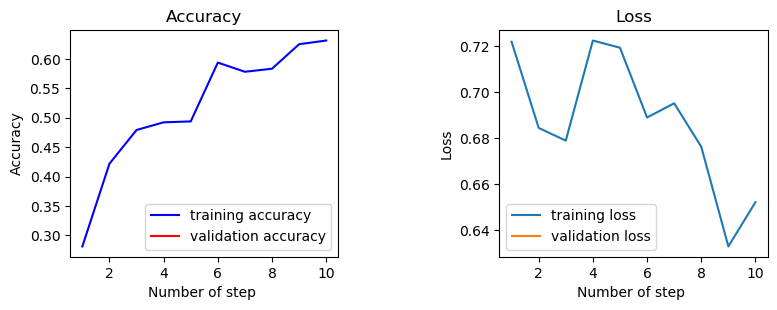

In [41]:
mm.plot_acc_loss(steps_loss_train=histories_per_step.steps, loss_train=histories_per_step.losses,
                 steps_acc_train=histories_per_step.steps, accuracy_train=histories_per_step.accuracies,
                 steps_loss_eval=histories_per_step.val_steps, loss_eval=histories_per_step.val_losses,
                 steps_acc_eval=histories_per_step.val_steps, accuracy_eval=histories_per_step.val_accuracies)

### Visualization using TenorBoard callback

In [42]:
history_train=mu.load_data_tensorboard(log_dir+'/train')
history_val=mu.load_data_tensorboard(log_dir+'/validation')
debug=False


if debug:
    print('\n')
    for file in glob.glob(log_dir+'/train/*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print('\nnumber of entry for train:', len(history_train['batch_loss'][0]))
    print('\n',history_train)
    print('\nnumber of entry for eval:', len(history_train['epoch_loss'][0]))
    print('\n',history_val)
    print('\n\n\n')

Loss:
  - loss [training dataset]: 0.652
  - loss [validation dataset: 0.694

Accuracy:
  - accuracy [training dataset]: 63.13%
  - accuracy [validation dataset: 52.60%


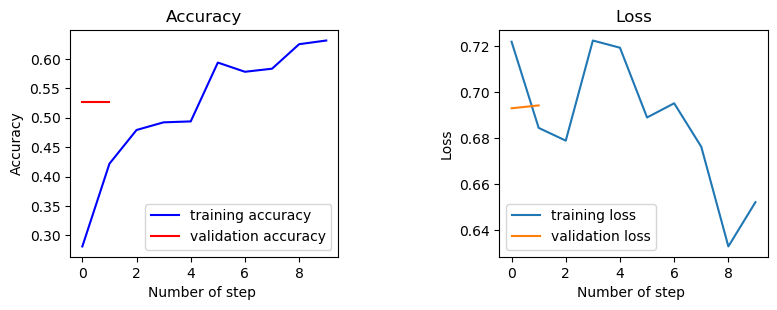

In [43]:
mm.plot_acc_loss(steps_loss_train=history_train['batch_loss'][0], loss_train=history_train['batch_loss'][1],
                 steps_acc_train=history_train['batch_accuracy'][0], accuracy_train=history_train['batch_accuracy'][1],
                 steps_loss_eval=history_val['epoch_loss'][0], loss_eval=history_val['epoch_loss'][1],
                 steps_acc_eval=history_val['epoch_accuracy'][0], accuracy_eval=history_val['epoch_accuracy'][1])

### Metadata

In [44]:
print(model.metrics)
print(model.metrics_names)

['loss', 'accuracy']


In [45]:
history.epoch

[0, 1]

In [46]:
history.params

{'batch_size': None,
 'epochs': 2,
 'steps': 5,
 'samples': 5,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [47]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [48]:
# dir(history)

### Exploration of the model's structure

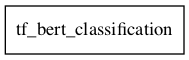

In [49]:
tf.keras.utils.plot_model(model,
                          'model.png',
                          show_shapes=True)

In [50]:
model.inputs

{'attention_mask': <tf.Tensor 'attention_mask:0' shape=(None, 128) dtype=int32>,
 'input_ids': <tf.Tensor 'input_ids:0' shape=(None, 128) dtype=int32>,
 'token_type_ids': <tf.Tensor 'token_type_ids:0' shape=(None, 128) dtype=int32>}

In [51]:
model.outputs

[<tf.Tensor 'tf_bert_classification/Identity:0' shape=(None, 2) dtype=float32>]

In [52]:
model.layers

In [53]:
# _inbound_nodes and inbound_nodes give the same !
# to see method available: dir(model.layers[2])
for layer in model.layers:
    print(layer.name, layer._inbound_nodes, layer._outbound_nodes)

bert [] []
dropout_37 [] []
classifier [] []


## Model's evaluation and validation

### Making prediction

In [54]:
# get probablility for each classes
if model.name=='custom_tf_bert_classification':
        print('custom model: {}'.format(model.name))
        y_pred = tf.nn.softmax(model.predict(valid_dataset))
elif model.name=='tf_bert_classification':
        print('standard model: {}'.format(model.name))
        y_pred = tf.squeeze(tf.nn.softmax(model.predict(valid_dataset)))

standard model: tf_bert_classification


In [55]:
y_pred.shape

TensorShape([872, 2])

In [56]:
# get predicted classes
y_pred_argmax = tf.math.argmax(y_pred, axis=1)        

In [57]:
(y_pred_argmax).shape

TensorShape([872])

### Extracting true classes

In [58]:
# extracting and flatten true classes
y_true_tf=valid_dataset.map(pp.label_extraction).flat_map(lambda x: valid_dataset.from_tensor_slices(x))

In [59]:
y_true=list(y_true_tf.as_numpy_iterator())

In [60]:
len(y_true), len(y_pred_argmax)

(872, 872)

### Model performanes

In [61]:
print(classification_report(y_true, y_pred_argmax, target_names=info.features["label"].names))

NameError: name 'info' is not defined

In [ ]:
mm.print_metrics(y_true, y_pred_argmax, mode='')

### Confusion matrix

In [ ]:
plt.rcParams['figure.figsize'] = [10, 7]

In [ ]:
mm.plot_confusion_matrix(confusion_matrix(y_true, y_pred_argmax), info.features["label"].names)

In [ ]:
mm.plot_confusion_matrix(confusion_matrix(y_true, y_pred_argmax), info.features["label"].names, normalize=True)

### ROC curves

In [ ]:
mm.roc_curves(to_categorical(y_true), y_pred.numpy(), info.features["label"].names)